## Project Overview
A complete machine learning pipeline predicting passenger survival on the Titanic using classification algorithms. This project demonstrates end-to-end data science workflow: exploratory data analysis (EDA), feature engineering, model training, and evaluation.

## Problem Statement
Build a predictive model that answers the question:
"What sorts of people were more likely to survive the Titanic disaster?" using passenger data (age, gender, socio-economic class, etc.).

## Dataset
Source: Kaggle Titanic Competition

Training Set: 891 samples with survival labels

Test Set: 418 samples for prediction submission

Features: 11 passenger attributes including class, age, fare, cabin, and family relations

## Technical Implementation

##Key Steps
### Data Preprocessing

Missing value imputation (Age, Cabin, Embarked)

Feature encoding (categorical to numerical)

Outlier detection and handling

### Feature Engineering

Title extraction from passenger names

Family size and alone status

Fare per person calculation

Cabin deck extraction

### Exploratory Data Analysis

Survival rate by gender, class, and age groups

Correlation matrix and feature relationships

Visualizations using Matplotlib and Seaborn

## Setup & Data Loading

In [11]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# === LOAD DATA ===
# Download from Kaggle
!wget -q https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv -O train.csv
!wget -q https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/test.csv -O test.csv

# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("TITANIC DATASET LOADED")
print(f"Training set: {train_df.shape}")
print(f"Test set: {test_df.shape}")
print("\nTraining columns:", train_df.columns.tolist())

TITANIC DATASET LOADED
Training set: (891, 12)
Test set: (418, 11)

Training columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


## Exploratory Data Analysis (EDA)

=== DATA OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

=== MISSING VALUES ===
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cab

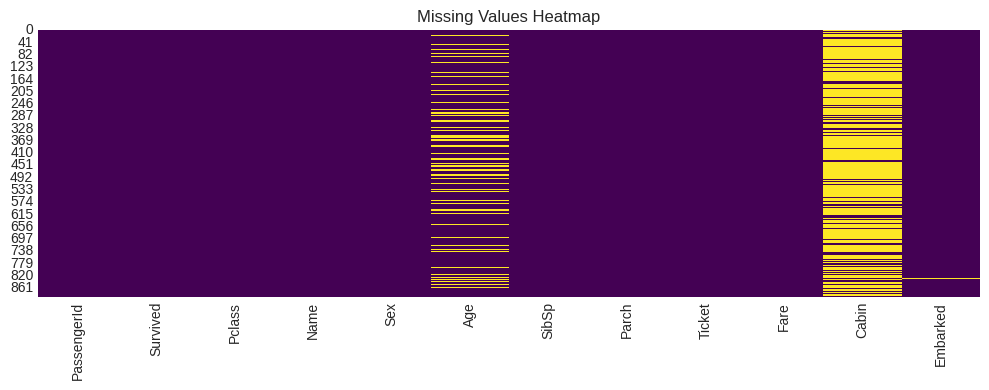


=== SURVIVAL RATE: 38.38% ===


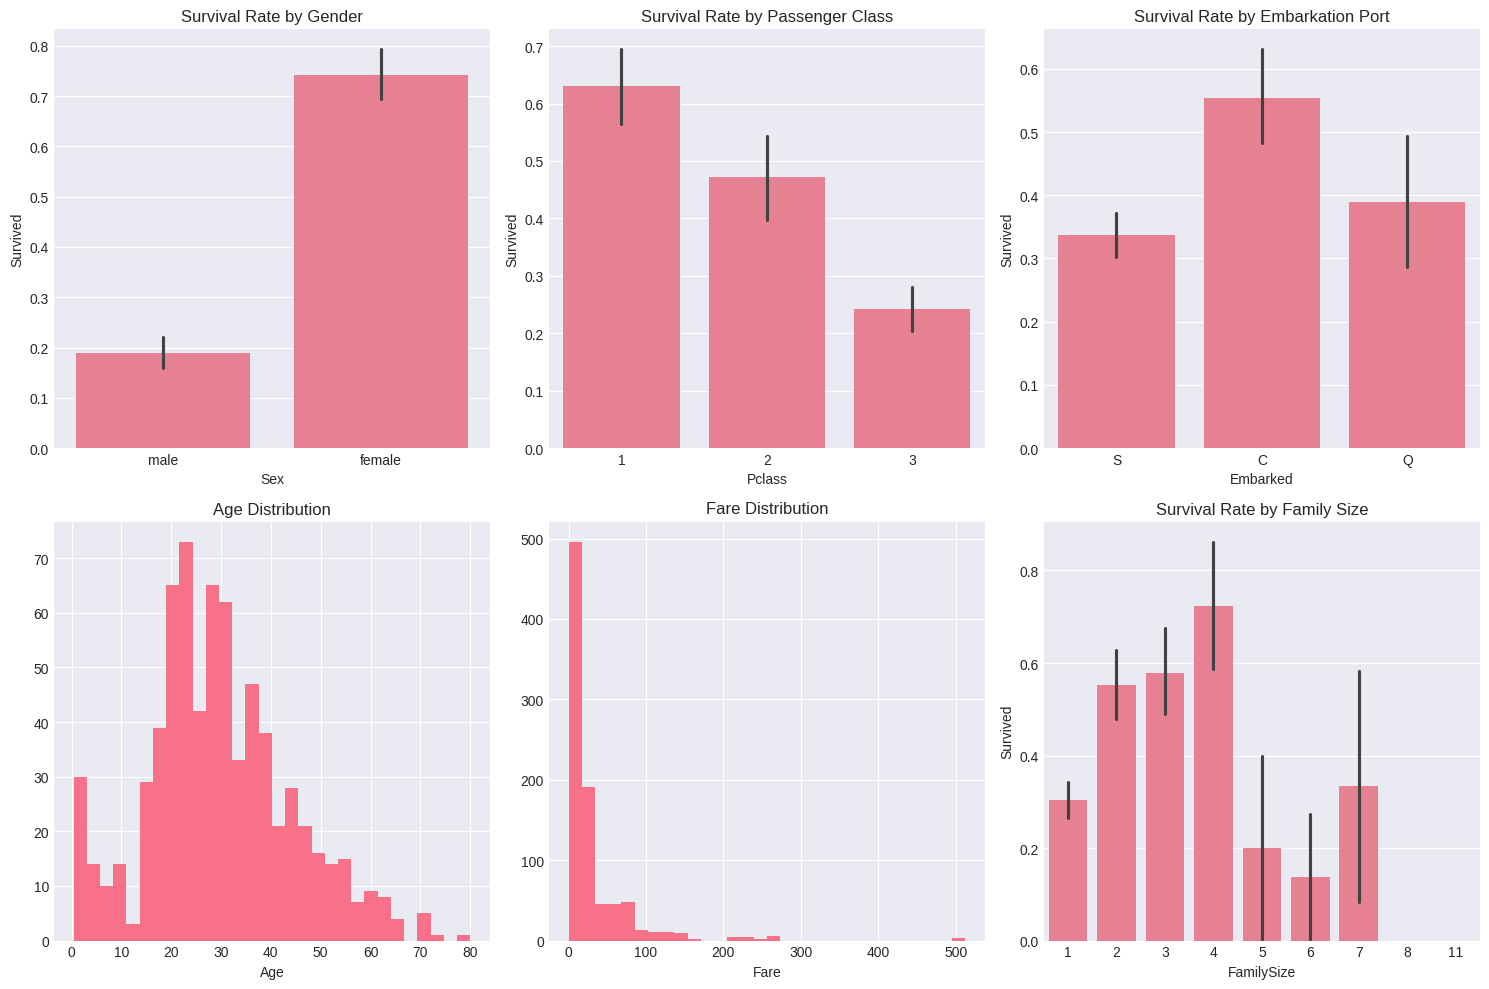

In [12]:
# === BASIC INFO ===
print("=== DATA OVERVIEW ===")
print(train_df.info())
print("\n=== MISSING VALUES ===")
print(train_df.isnull().sum())

# VISUALIZE MISSING DATA
plt.figure(figsize=(10, 4))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

# SURVIVAL DISTRIBUTION
print(f"\n=== SURVIVAL RATE: {train_df['Survived'].mean():.2%} ===")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Survival by Gender
sns.barplot(x='Sex', y='Survived', data=train_df, ax=axes[0, 0])
axes[0, 0].set_title('Survival Rate by Gender')

# Plot 2: Survival by Class
sns.barplot(x='Pclass', y='Survived', data=train_df, ax=axes[0, 1])
axes[0, 1].set_title('Survival Rate by Passenger Class')

# Plot 3: Survival by Embarkation
sns.barplot(x='Embarked', y='Survived', data=train_df, ax=axes[0, 2])
axes[0, 2].set_title('Survival Rate by Embarkation Port')

# Plot 4: Age Distribution
train_df['Age'].hist(bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution')
axes[1, 0].set_xlabel('Age')

# Plot 5: Fare Distribution
train_df['Fare'].hist(bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Fare Distribution')
axes[1, 1].set_xlabel('Fare')

# Plot 6: Family Size
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
sns.barplot(x='FamilySize', y='Survived', data=train_df, ax=axes[1, 2])
axes[1, 2].set_title('Survival Rate by Family Size')

plt.tight_layout()
plt.show()

## Feature Engineering

In [13]:
# CREATE A COPY FOR PROCESSING
def feature_engineering(df):
    df_copy = df.copy()

    # 1. Extract Title from Name
    df_copy['Title'] = df_copy['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    # Group rare titles
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Ms': 'Miss', 'Lady': 'Rare', 'Countess': 'Rare',
        'Capt': 'Rare', 'Sir': 'Rare', 'Don': 'Rare', 'Jonkheer': 'Rare',
        'Dona': 'Rare', 'Mme': 'Mrs'
    }
    df_copy['Title'] = df_copy['Title'].map(title_mapping)

    # 2. Fill missing Age based on Title median
    title_age_median = df_copy.groupby('Title')['Age'].median()
    df_copy['Age'] = df_copy.apply(
        lambda row: title_age_median[row['Title']] if pd.isnull(row['Age']) else row['Age'],
        axis=1
    )

    # 3. Create Age Groups
    df_copy['AgeGroup'] = pd.cut(df_copy['Age'],
                                  bins=[0, 12, 18, 35, 60, 100],
                                  labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])

    # 4. Fill missing Embarked with mode
    df_copy['Embarked'].fillna(df_copy['Embarked'].mode()[0], inplace=True)

    # 5. Fill missing Fare with median
    df_copy['Fare'].fillna(df_copy['Fare'].median(), inplace=True)

    # 6. Cabin feature - has cabin or not
    df_copy['HasCabin'] = df_copy['Cabin'].notna().astype(int)

    # 7. Family features
    df_copy['FamilySize'] = df_copy['SibSp'] + df_copy['Parch'] + 1
    df_copy['IsAlone'] = (df_copy['FamilySize'] == 1).astype(int)

    # 8. Fare per person
    df_copy['FarePerPerson'] = df_copy['Fare'] / df_copy['FamilySize']

    # 9. Drop unnecessary columns
    columns_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId']
    df_copy.drop([col for col in columns_to_drop if col in df_copy.columns],
                 axis=1, inplace=True, errors='ignore')

    return df_copy

# Apply to both datasets
train_processed = feature_engineering(train_df)
test_processed = feature_engineering(test_df)

print("Feature engineering complete!")
print(f"New training shape: {train_processed.shape}")
print(f"New columns: {train_processed.columns.tolist()}")

Feature engineering complete!
New training shape: (891, 14)
New columns: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title', 'AgeGroup', 'HasCabin', 'IsAlone', 'FarePerPerson']


## Data Preprocessing

In [14]:
# ENCODE CATEGORICAL VARIABLES
def encode_features(df):
    df_encoded = df.copy()

    # Label encoding for categorical features
    categorical_cols = ['Sex', 'Embarked', 'Title', 'AgeGroup']

    for col in categorical_cols:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

    return df_encoded

train_encoded = encode_features(train_processed)
test_encoded = encode_features(test_processed)

# PREPARE TRAIN/TEST SPLIT
X = train_encoded.drop('Survived', axis=1)
y = train_encoded['Survived']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (712, 13)
Validation set: (179, 13)


## Model Training & Evaluation

=== RANDOM FOREST RESULTS ===
Accuracy: 0.7877

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       110
           1       0.72      0.72      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179


=== LOGISTIC REGRESSION RESULTS ===
Accuracy: 0.7933


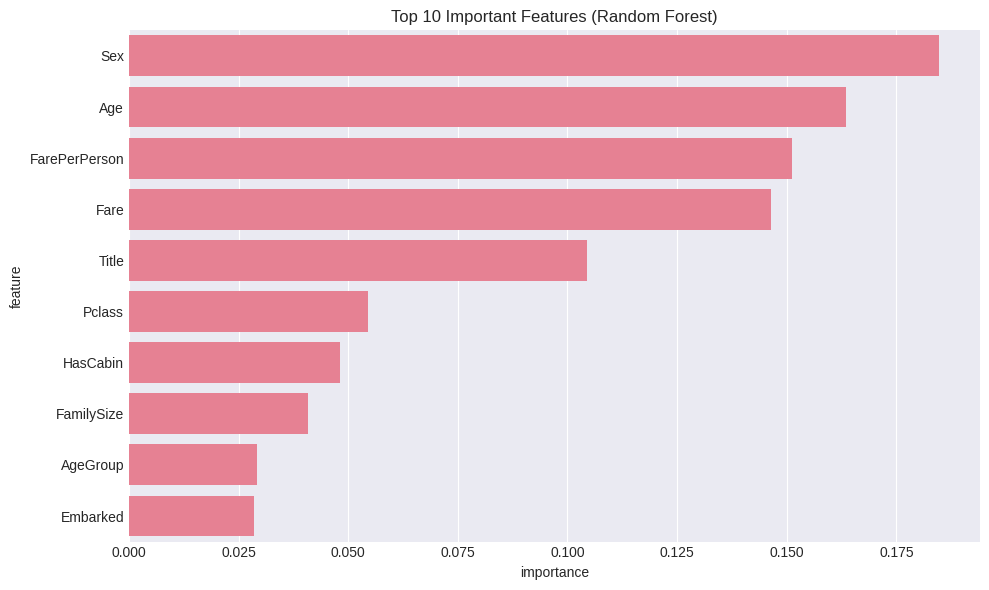

In [15]:
# MODEL 1: RANDOM FOREST
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_val)

print("=== RANDOM FOREST RESULTS ===")
print(f"Accuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf))

# MODEL 2: LOGISTIC REGRESSION
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_val)

print("\n=== LOGISTIC REGRESSION RESULTS ===")
print(f"Accuracy: {accuracy_score(y_val, y_pred_lr):.4f}")

# FEATURE IMPORTANCE
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features (Random Forest)')
plt.tight_layout()
plt.show()

## Make Predictions on Test Set

In [16]:
# Ensure test set has same columns as training set
missing_cols = set(X.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0

# Reorder columns to match training
test_encoded = test_encoded[X.columns]

# Make final predictions
final_predictions = rf_model.predict(test_encoded)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': final_predictions
})

submission.to_csv('titanic_submission.csv', index=False)
print(f"Survival rate in predictions: {final_predictions.mean():.2%}")

Survival rate in predictions: 38.52%
